In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pyrtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.4/115.4 kB 1.3 MB/s eta 0:00:00


In [3]:
!pip install librosa

In [4]:
import pyrtools as pt
import cv2 as cv
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from time import time
from scipy.io.wavfile import write
import librosa
import librosa.display
import wave

In [5]:
#here the path of the required video in drive must be given
video_dir = "/content/drive/MyDrive/Chips2-2200Hz-Mary_MIDI-input.avi"

In [6]:
# Load the input audio file
audio_path = '/content/Chips2-2200Hz-Mary_MIDI-input.wav'

In [7]:
def plot_waveform(audio_path,title):
  # Open the audio file
  with wave.open(audio_path, 'rb') as wav_file:
    # Get audio parameters
    sample_rate = wav_file.getframerate()
    n_samples = wav_file.getnframes()
    # Read all frames
    signal = wav_file.readframes(n_samples)

  # Convert the data to a NumPy array
  audio_data = np.frombuffer(signal, dtype=np.int16)

  # Calculate time axis
  time = np.arange(0, len(audio_data) / sample_rate, 1 / sample_rate)

  # Plot the waveform
  plt.figure(figsize=(16,6))
  plt.plot(time, audio_data)
  plt.xlabel('Time (sec)')
  plt.ylabel('Amplitude')
  plt.title('{}'.format(title))
  plt.show()

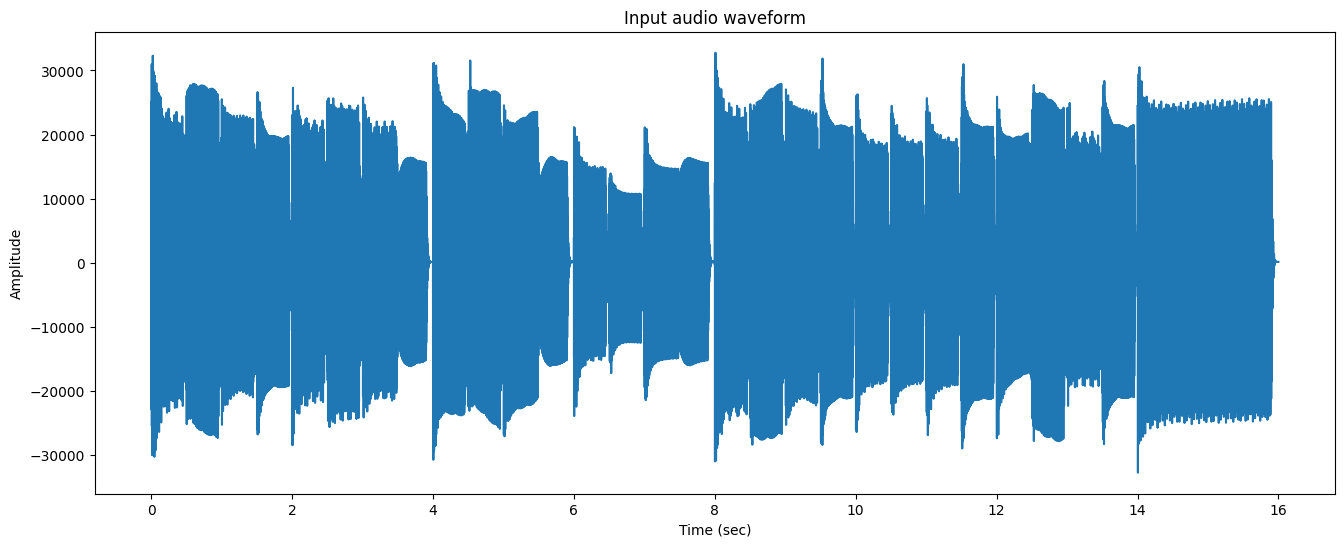

In [8]:
plot_waveform(audio_path,"Input audio waveform")

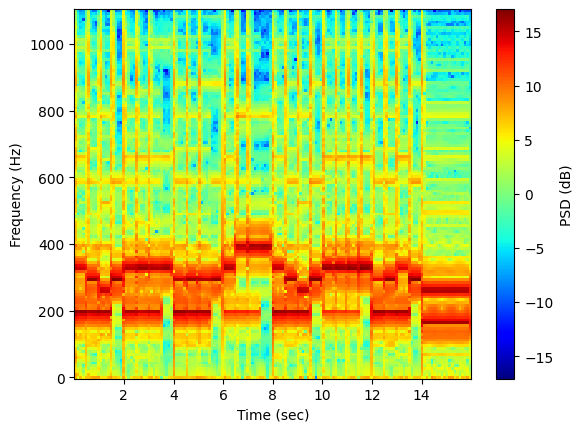

In [9]:
sample_rate, samples = wavfile.read(audio_path)
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

plt.pcolormesh(times, frequencies,np.log(spectrogram),cmap='jet')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.colorbar().set_label('PSD (dB)')
plt.show()

In [10]:
'''
All functions written here is an implementation of the paper on
Visual Microphone(http://people.csail.mit.edu/mrub/VisualMic/)
by MIT. The algorithm and functions are inspired by the MATLAB code provided
by MIT.
'''
class VM:
    '''
    Designed the entire algorithm in Object oriented model architecture
    '''
    def __init__(self, video_path):
        self.video_object = cv.VideoCapture(video_path)
        self.nframes = nframes=int(self.video_object.get(cv.CAP_PROP_FRAME_COUNT))
        self.sr=2200

    def align(self,x,y):
        '''
        Function to align vectors before averaging as mentioned in formula 4 of paper
        x,y : np.array
        '''
        tshift = np.argmax(np.convolve(x,np.flip(y))) #y flip check before final
        shift = y.size - tshift
        return np.roll(x,shift)

    def plot_spectogram(self,x,fs=2200,save=False):
        '''
        Function to plot spectrogram given sound array
        -------
        Parameters:
        x    : numpy array to be plotted in spectogram
        fs   : sample frequency
        '''
        plt.figure()
        plt.specgram(x, Fs=fs,cmap=plt.get_cmap('jet'))
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')
        plt.colorbar().set_label('PSD (dB)')
        plt.savefig("spectogram")

    def get_scaled_sound(self,sound):
        '''
        This function is to scale recovered sound to make it audible.
        ---------
        Parameters:
        sound :  numpy area of recovered sound to be scaled
        '''
        maxs=np.max(sound)
        mins=np.min(sound)

        if maxs!=1.0 or mins!=-1.0:
            rangev = maxs-mins
            sound = 2*sound/rangev
            newmax = np.max(sound)
            offset=newmax - 1.0
            sound-=offset

        return sound

    def save_audio(self,file_name,sound,sr=0):
      '''
      Parameters
      ---------
      file_name : Name of file when saved
      sound     : Sound array
      sr        : Sample rate
      '''
      if sr==0:
        sr=self.sr
      write(file_name, sr, x)


    def sound_from_video(self,nscale,norientation,downsample_factor,sample_rate=2200):
        '''
        This function recovers sound from the video
        ------
        Parameters:
        nscale      :   number of scales to steer each frames complex steerable pyramid
        norientation  : number of orientations to iterate over in each frame's complex steerable pyramid
        downsample_factor: to reduce running time
        '''
        nframes=self.nframes
        self.sr=sample_rate
        video=self.video_object

        suc,frame = video.read() #reading first frame and considering it reference frame

        if downsample_factor < 1:
            scaled_frame = cv.resize(frame, (0, 0), fx=downsample_factor, fy=downsample_factor)
        else:
            scaled_frame = frame

        gray_frame = cv.cvtColor(scaled_frame, cv.COLOR_BGR2GRAY)
        norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)

        first_pyr = pt.pyramids.SteerablePyramidFreq(norm_frame,nscale,norientation-1,is_complex=True)
        first_pyr=first_pyr.pyr_coeffs
        first_coeff=dict()
        recovered_signal=dict()

        for band,coefficient in first_pyr.items():
            first_coeff[band]=coefficient
            recovered_signal[band]=list()

        iter=1
        time_start = time()
        time_present=time()

        while suc: #iterating over each frame
            iter+=1

            if downsample_factor < 1:
                frame = cv.resize(frame, (0,0), fx=downsample_factor, fy=downsample_factor)

            gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            norm_frame = cv.normalize(gray_frame.astype('float'), None, 0.0, 1.0, cv.NORM_MINMAX)
            pyramid = pt.pyramids.SteerablePyramidFreq(norm_frame, nscale, norientation - 1, is_complex=True)
            pyramid=pyramid.pyr_coeffs
            amp_pyr=dict()

            for band,coefficient in pyramid.items():
                amp_pyr[band] = abs(coefficient)

            phase_diff_pyr = dict()

            for band,coefficient in pyramid.items():
                phase_diff_pyr[band] = np.mod(math.pi + np.angle(coefficient)-np.angle(first_coeff[band]),2*math.pi) - math.pi

            for band in pyramid.keys():
                amp=amp_pyr[band]
                phase_diff=phase_diff_pyr[band]
                lms=np.multiply(phase_diff, np.multiply(amp, amp))
                amp_net = np.sum(amp.flatten())
                recovered_signal[band].append(np.mean(lms.flatten())/amp_net)
            suc,frame=video.read()
            time_present = time()

            if(iter%500==0):
              print("Progress done: "+str(iter/nframes*100)+"% "+"after "+str(time_present-time_start)+"s.")
        recov_sound=np.zeros(nframes)
        try:
            for rsignal in recovered_signal.values():
                recov_sound+=self.align(np.array(rsignal),np.array(recovered_signal[(0,0)]))
        except:
            print("error")

        sos = signal.butter(3, 0.05, btype='highpass', output='sos')
        filtered_sound = signal.sosfilt(sos, recov_sound)
        filtered_sound = self.get_scaled_sound(filtered_sound)

        return filtered_sound

In [11]:
vm = VM(video_dir)

In [ ]:
x=vm.sound_from_video(1,2,0.1)

Progress done: 1.3129217761205787% after 6.140780925750732s.
Progress done: 2.6258435522411574% after 12.195122241973877s.
Progress done: 3.938765328361736% after 17.073835372924805s.
Progress done: 5.251687104482315% after 25.385151624679565s.
Progress done: 6.564608880602894% after 30.815982580184937s.
Progress done: 7.877530656723472% after 37.89228391647339s.
Progress done: 9.190452432844051% after 43.03528714179993s.
Progress done: 10.50337420896463% after 48.08372449874878s.
Progress done: 11.816295985085208% after 54.58367848396301s.
Progress done: 13.129217761205789% after 59.31576752662659s.
Progress done: 14.442139537326366% after 65.98179197311401s.
Progress done: 15.755061313446944% after 71.01768851280212s.
Progress done: 17.067983089567523% after 77.01111173629761s.
Progress done: 18.380904865688102% after 82.34960103034973s.
Progress done: 19.69382664180868% after 87.79341316223145s.
Progress done: 21.00674841792926% after 93.27854251861572s.
Progress done: 22.3196701940

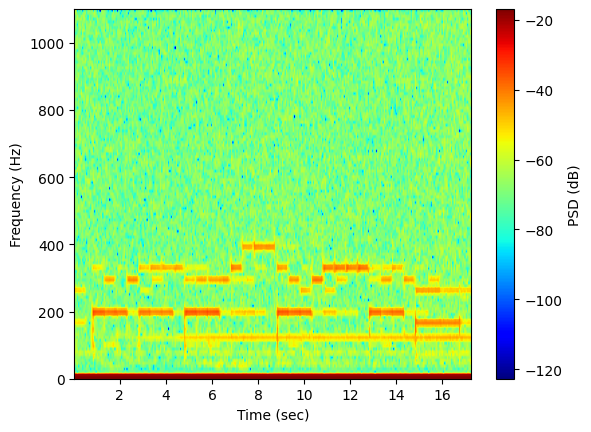

In [ ]:
vm.plot_spectogram(x,2200)

In [ ]:
vm.save_audio('test.wav',x)

In [ ]:
output_path = '/content/test.wav'
plot_waveform(output_path,"Recovered audio waveform")